# ⚠️ Important: Correct Spelling

## How to Write "Hyperparameter" Correctly

**✅ Correct:** `hyperparameter` (with 'r' after 'p')

**❌ Common Mistakes:**
- `hyperpameter` ← missing 'r'
- `hyperparmeter` ← wrong letter order
- `hyperparamter` ← wrong letter order

**Thai (ภาษาไทย):** ไฮเปอร์พารามิเตอร์

### How to Remember:
1. Think of "**hyper**" (ไฮเปอร์) + "**parameter**" (พารามิเตอร์)
2. Remember: There are **two 'r's**: hype**r**-pa**r**ameter

### What are Hyperparameters?
**Hyperparameters** are configuration settings that you must set **before** training a model. They control the learning process but are not learned from the data.

**Examples:**
- `max_depth`: Maximum depth of a decision tree
- `learning_rate`: How fast a model learns
- `n_estimators`: Number of trees in a random forest

**Note:** This notebook compares different **hyperparameter tuning** methods!

📖 **For more details, see:**
- `README.md` (English guide)
- `SPELLING_GUIDE.md` (Thai language guide)

---


In [26]:
# ==========================================
# 🔬 เปรียบเทียบวิธี Hyperparameter Tuning
# สำหรับ Decision Tree Model เดียว
# ==========================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import os
from time import time
from scipy. stats import randint, uniform

# Models & Tools
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import (RandomizedSearchCV, GridSearchCV, 
                                      StratifiedKFold, cross_val_score)
from sklearn.metrics import (accuracy_score, recall_score, precision_score, 
                             f1_score, roc_auc_score, confusion_matrix,
                             balanced_accuracy_score, classification_report,
                             make_scorer)

# Bayesian Optimization
try:
    from skopt import BayesSearchCV
    from skopt.space import Real, Categorical, Integer
    BAYESIAN_AVAILABLE = True
except ImportError: 
    print("⚠️  scikit-optimize not installed. Install with: pip install scikit-optimize")
    BAYESIAN_AVAILABLE = False

# Optuna (Alternative Bayesian)
try:
    import optuna
    from optuna. integration import OptunaSearchCV
    OPTUNA_AVAILABLE = True
except ImportError:
    print("⚠️  Optuna not installed. Install with: pip install optuna")
    OPTUNA_AVAILABLE = False

# Imbalance Handling
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline


⚠️  scikit-optimize not installed. Install with: pip install scikit-optimize
⚠️  Optuna not installed. Install with: pip install optuna


In [27]:
# ==========================================
# 📦 1. Load Data
# ==========================================
print("="*80)
print("📦 Loading Data...")
print("="*80)

path = '/Users/tanananyathongkum/Jenny/Project/Heart Disease/PJ 2/Data_Split/'

X_train_full = pd.read_csv(f'{path}X_train_90.csv')
y_train = pd.read_csv(f'{path}y_train_90.csv').squeeze()
X_test_full = pd.read_csv(f'{path}X_test_10.csv')
y_test = pd.read_csv(f'{path}y_test_10.csv').squeeze()

# Load selected features
selected_features = joblib.load('models/rfe_best_features.pkl')
X_train = X_train_full[selected_features]
X_test = X_test_full[selected_features]

print(f"✅ Data loaded:  {X_train.shape}")
print(f"✅ Features:  {len(selected_features)}")



📦 Loading Data...
✅ Data loaded:  (9000, 10)
✅ Features:  10


In [28]:
# ==========================================
# 🔧 2. Define Parameter Space (เหมือนกันทุกวิธี)
# ==========================================

# สำหรับ RandomizedSearchCV & GridSearchCV
param_distributions = {
    'model__criterion': ['gini', 'entropy'],
    'model__max_depth': randint(3, 21),  # 3-20
    'model__min_samples_split': randint(10, 100),
    'model__min_samples_leaf': randint(5, 50),
    'model__max_features': [None, 'sqrt', 'log2', 0.5, 0.7],
    'model__class_weight': ['balanced', {0:1, 1:3}, {0:1, 1:4}, {0:1, 1:5}],
    'model__ccp_alpha': uniform(0.0, 0.05),
    'model__min_impurity_decrease': uniform(0.0, 0.01)
}

# สำหรับ GridSearchCV (ต้องเป็น list ไม่ใช่ distribution)
param_grid = {
    'model__criterion': ['gini', 'entropy'],
    'model__max_depth': [3, 5, 7, 10, 15, 20],
    'model__min_samples_split': [10, 20, 40, 60, 80],
    'model__min_samples_leaf': [5, 10, 20, 30, 40],
    'model__max_features': [None, 'sqrt', 'log2', 0.5, 0.7],
    'model__class_weight': ['balanced', {0:1, 1:3}, {0:1, 1:4}],
    'model__ccp_alpha': [0.0, 0.01, 0.02, 0.03, 0.04],
    'model__min_impurity_decrease': [0.0, 0.002, 0.005, 0.008]
}

# สำหรับ BayesianOptimization (ต้องเป็น search space objects)
if BAYESIAN_AVAILABLE: 
    from skopt.space import Real, Categorical, Integer
    
    bayesian_space = {
        'model__criterion': Categorical(['gini', 'entropy']),
        'model__max_depth': Integer(3, 20),
        'model__min_samples_split': Integer(10, 100),
        'model__min_samples_leaf': Integer(5, 50),
        'model__max_features': Categorical([None, 'sqrt', 'log2', 0.5, 0.7]),
        'model__class_weight': Categorical(['balanced', {0:1, 1:3}, {0:1, 1:4}, {0:1, 1:5}]),
        'model__ccp_alpha': Real(0.0, 0.05, prior='uniform'),
        'model__min_impurity_decrease': Real(0.0, 0.01, prior='uniform')
    }

print("\n✅ Parameter spaces defined")



✅ Parameter spaces defined


In [29]:
# ==========================================
# 🎯 3. Define Tuning Methods
# ==========================================

def evaluate_tuning_method(method_name, search_object, X_train, y_train, X_test, y_test):
    """
    ประเมินวิธี tuning แต่ละแบบ
    """
    print(f"\n{'='*80}")
    print(f"🔬 Testing:  {method_name}")
    print(f"{'='*80}")
    
    start = time()
    
    # Fit
    try:
        search_object.fit(X_train, y_train)
        fit_success = True
    except Exception as e:
        print(f"❌ Error during fitting: {str(e)}")
        return None
    
    elapsed = time() - start
    
    # Get best model
    best_model = search_object.best_estimator_
    best_params = search_object.best_params_
    
    # CV results
    if hasattr(search_object, 'cv_results_'):
        cv_results = pd.DataFrame(search_object.cv_results_)
        best_idx = search_object.best_index_
        
        cv_bal_acc = cv_results.loc[best_idx, 'mean_test_score']
        cv_bal_acc_std = cv_results.loc[best_idx, 'std_test_score']
        
        # Train score (if available)
        if 'mean_train_score' in cv_results.columns:
            train_bal_acc = cv_results.loc[best_idx, 'mean_train_score']
            gap = train_bal_acc - cv_bal_acc
        else:
            train_bal_acc = np.nan
            gap = np.nan
    else:
        cv_bal_acc = search_object.best_score_
        cv_bal_acc_std = np.nan
        train_bal_acc = np.nan
        gap = np.nan
    
    print(f"\n📊 Cross-Validation Results:")
    print(f"   Best CV Score:         {cv_bal_acc:.4f} ± {cv_bal_acc_std:.4f if not np.isnan(cv_bal_acc_std) else 'N/A'}")
    if not np.isnan(gap):
        print(f"   Train CV Score:       {train_bal_acc:.4f}")
        print(f"   Train-CV Gap:         {gap:.4f}")
    
    print(f"\n🔧 Best Hyperparameters:")
    for param, value in sorted(best_params.items()):
        print(f"   {param}: {value}")
    
    # Test evaluation
    y_pred = best_model.predict(X_test)
    y_pred_proba = best_model.predict_proba(X_test)[:, 1]
    
    test_acc = accuracy_score(y_test, y_pred)
    test_bal_acc = balanced_accuracy_score(y_test, y_pred)
    test_rec = recall_score(y_test, y_pred, zero_division=0)
    test_prec = precision_score(y_test, y_pred, zero_division=0)
    test_f1 = f1_score(y_test, y_pred, zero_division=0)
    test_roc_auc = roc_auc_score(y_test, y_pred_proba)
    cm = confusion_matrix(y_test, y_pred)
    
    print(f"\n⏱️  Training Time: {elapsed:.2f}s ({elapsed/60:.2f} min)")
    print(f"\n📊 Test Set Results:")
    print(f"   Accuracy:          {test_acc:. 4f}")
    print(f"   Balanced Accuracy: {test_bal_acc:.4f}")
    print(f"   Precision:         {test_prec:. 4f}")
    print(f"   Recall:            {test_rec:.4f}")
    print(f"   F1-Score:          {test_f1:.4f}")
    print(f"   ROC-AUC:           {test_roc_auc:.4f}")
    
    print(f"\n🔲 Confusion Matrix:")
    print(f"   TN={cm[0,0]: <4} FP={cm[0,1]: <4}")
    print(f"   FN={cm[1,0]:<4} TP={cm[1,1]:<4}")
    
    # Number of iterations
    if hasattr(search_object, 'n_iter'):
        n_iterations = search_object.n_iter
    elif hasattr(search_object, 'cv_results_'):
        n_iterations = len(cv_results)
    else:
        n_iterations = np.nan
    
    print(f"\n📈 Search Statistics:")
    print(f"   Total Iterations:   {n_iterations if not np.isnan(n_iterations) else 'N/A'}")
    print(f"   Time per Iter:     {elapsed/n_iterations:.2f}s" if not np.isnan(n_iterations) else "   Time per Iter: N/A")
    
    # Convergence analysis (for Bayesian methods)
    if hasattr(search_object, 'cv_results_') and len(cv_results) > 1:
        scores = cv_results['mean_test_score']. values
        best_so_far = np.maximum.accumulate(scores)
        improvement_rate = (best_so_far[-1] - best_so_far[0]) / len(best_so_far)
        
        print(f"   Improvement Rate:   {improvement_rate:.6f} per iteration")
        print(f"   Converged:          {'Yes' if improvement_rate < 0.0001 else 'No'}")
    
    return {
        'Method': method_name,
        'CV_Score': cv_bal_acc,
        'CV_Std': cv_bal_acc_std,
        'Train_Score': train_bal_acc,
        'Train_CV_Gap': gap,
        'Test_Accuracy': test_acc,
        'Test_Balanced_Acc': test_bal_acc,
        'Test_Precision': test_prec,
        'Test_Recall': test_rec,
        'Test_F1':  test_f1,
        'Test_ROC_AUC': test_roc_auc,
        'Time_sec': elapsed,
        'Time_min': elapsed/60,
        'N_Iterations': n_iterations,
        'Time_per_Iter': elapsed/n_iterations if not np.isnan(n_iterations) else np.nan,
        'Best_Params': best_params,
        'Confusion_Matrix': cm. tolist()
    }, best_model



In [30]:
# ==========================================
# 🧪 4. Setup All Tuning Methods
# ==========================================

print("\n" + "="*80)
print("🧪 SETTING UP TUNING METHODS")
print("="*80)

# CV Strategy
cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Scoring
scoring = 'balanced_accuracy'

# Base pipeline - ใช้ k_neighbors น้อยลงเพื่อรองรับ small folds
def create_pipeline():
    return ImbPipeline([
        ('sampler', SMOTE(k_neighbors=2, random_state=42)),  # ลดจาก 5 เป็น 2
        ('model', DecisionTreeClassifier(random_state=42))
    ])

# Dictionary to store all methods
tuning_methods = {}



🧪 SETTING UP TUNING METHODS


In [31]:
# ==========================================
# Method 1: RandomizedSearchCV
# ==========================================
print("\n1️⃣  RandomizedSearchCV")
tuning_methods['RandomizedSearchCV'] = RandomizedSearchCV(
    estimator=create_pipeline(),
    param_distributions=param_distributions,
    n_iter=100,  # จำนวน combinations ที่จะทดสอบ
    cv=cv_strategy,
    scoring=scoring,
    n_jobs=-1,
    random_state=42,
    verbose=0,
    return_train_score=True
)
print("   ✅ Configured:  100 random combinations")




1️⃣  RandomizedSearchCV
   ✅ Configured:  100 random combinations


In [32]:
# ==========================================
# Method 2: GridSearchCV
# ==========================================
print("\n2️⃣  GridSearchCV")

# คำนวณจำนวน combinations
n_combinations = 1
for param_values in param_grid.values():
    n_combinations *= len(param_values)

print(f"   ⚠️  Total combinations: {n_combinations: ,}")
print(f"   ⚠️  Estimated time: {n_combinations * 0.5 / 60:.1f} - {n_combinations * 2 / 60:.1f} minutes")

# ถ้าเยอะเกินไป ให้ลดลง
if n_combinations > 1000:
    print(f"   🔧 Reducing grid size to prevent explosion...")
    param_grid_reduced = {
        'model__criterion': ['gini', 'entropy'],
        'model__max_depth': [5, 10, 15],
        'model__min_samples_split': [10, 40, 80],
        'model__min_samples_leaf': [5, 20, 40],
        'model__max_features': ['sqrt', 0.5],
        'model__class_weight': ['balanced', {0:1, 1:4}],
        'model__ccp_alpha': [0.0, 0.02],
        'model__min_impurity_decrease': [0.0, 0.005]
    }
    
    n_combinations_reduced = 1
    for param_values in param_grid_reduced.values():
        n_combinations_reduced *= len(param_values)
    
    print(f"   ✅ Reduced to:  {n_combinations_reduced:,} combinations")
    
    tuning_methods['GridSearchCV'] = GridSearchCV(
        estimator=create_pipeline(),
        param_grid=param_grid_reduced,
        cv=cv_strategy,
        scoring=scoring,
        n_jobs=-1,
        verbose=0,
        return_train_score=True
    )
else:
    tuning_methods['GridSearchCV'] = GridSearchCV(
        estimator=create_pipeline(),
        param_grid=param_grid,
        cv=cv_strategy,
        scoring=scoring,
        n_jobs=-1,
        verbose=0,
        return_train_score=True
    )
    print(f"   ✅ Configured: {n_combinations:,} combinations")



2️⃣  GridSearchCV
   ⚠️  Total combinations:  90,000
   ⚠️  Estimated time: 750.0 - 3000.0 minutes
   🔧 Reducing grid size to prevent explosion...
   ✅ Reduced to:  864 combinations


In [33]:
# ==========================================
# Method 3: BayesSearchCV (Bayesian Optimization)
# ==========================================
if BAYESIAN_AVAILABLE: 
    print("\n3️⃣  BayesSearchCV (Bayesian Optimization)")
    tuning_methods['BayesSearchCV'] = BayesSearchCV(
        estimator=create_pipeline(),
        search_spaces=bayesian_space,
        n_iter=100,  # จำนวน iterations
        cv=cv_strategy,
        scoring=scoring,
        n_jobs=-1,
        random_state=42,
        verbose=0,
        return_train_score=True
    )
    print("   ✅ Configured: 100 Bayesian iterations")
else:
    print("\n3️⃣  BayesSearchCV:  ❌ Not available (install scikit-optimize)")




3️⃣  BayesSearchCV:  ❌ Not available (install scikit-optimize)


In [34]:
# ==========================================
# Method 4: OptunaSearchCV (Optuna)
# ==========================================
if OPTUNA_AVAILABLE: 
    print("\n4️⃣  OptunaSearchCV")
    
    # Optuna needs different format
    optuna_params = {
        'model__criterion': ['gini', 'entropy'],
        'model__max_depth': [3, 20],
        'model__min_samples_split': [10, 100],
        'model__min_samples_leaf': [5, 50],
        'model__max_features': [None, 'sqrt', 'log2', 0.5, 0.7],
        'model__class_weight': ['balanced', {0:1, 1:3}, {0:1, 1:4}],
        'model__ccp_alpha': [0.0, 0.05],
        'model__min_impurity_decrease': [0.0, 0.01]
    }
    
    tuning_methods['OptunaSearchCV'] = OptunaSearchCV(
        estimator=create_pipeline(),
        param_distributions=optuna_params,
        n_trials=100,
        cv=cv_strategy,
        scoring=scoring,
        n_jobs=-1,
        random_state=42,
        verbose=0,
        return_train_score=True
    )
    print("   ✅ Configured: 100 Optuna trials")
else:
    print("\n4️⃣  OptunaSearchCV:  ❌ Not available (install optuna)")



4️⃣  OptunaSearchCV:  ❌ Not available (install optuna)


In [35]:
# ==========================================
# Method 5: Halving Random Search (Fast)
# ==========================================
try:
    from sklearn.experimental import enable_halving_search_cv
    from sklearn.model_selection import HalvingRandomSearchCV
    
    print("\n5️⃣  HalvingRandomSearchCV (Successive Halving)")
    tuning_methods['HalvingRandomSearch'] = HalvingRandomSearchCV(
        estimator=create_pipeline(),
        param_distributions=param_distributions,
        n_candidates=100,  # initial candidates
        cv=cv_strategy,
        scoring=scoring,
        n_jobs=-1,
        random_state=42,
        verbose=0,
        return_train_score=True
    )
    print("   ✅ Configured:  Successive halving with 100 initial candidates")
except ImportError: 
    print("\n5️⃣  HalvingRandomSearchCV: ❌ Not available (requires sklearn >= 1.0)")

print("\n✅ All methods configured!")


5️⃣  HalvingRandomSearchCV (Successive Halving)
   ✅ Configured:  Successive halving with 100 initial candidates

✅ All methods configured!


In [36]:
# ==========================================
# 🚀 5. Run All Tuning Methods
# ==========================================

print("\n" + "="*80)
print("🚀 RUNNING ALL TUNING METHODS")
print("="*80)
print("⚠️  This may take a while...  Go grab a coffee!  ☕")

results = []
trained_models = {}

for method_name, search_object in tuning_methods.items():
    try:
        result_tuple = evaluate_tuning_method(
            method_name, 
            search_object, 
            X_train, y_train, 
            X_test, y_test
        )
        
        # ตรวจสอบว่า return None หรือไม่
        if result_tuple is not None:
            result, model = result_tuple
            results.append(result)
            trained_models[method_name] = model
            
            # Save model
            os.makedirs('models/tuning_comparison', exist_ok=True)
            joblib.dump(model, f'models/tuning_comparison/{method_name}.pkl')
        else:
            print(f"⚠️  {method_name} returned no results (skipped)")
            
    except Exception as e:
        print(f"❌ Error with {method_name}: {str(e)}")
        continue



🚀 RUNNING ALL TUNING METHODS
⚠️  This may take a while...  Go grab a coffee!  ☕

🔬 Testing:  RandomizedSearchCV


/Users/tanananyathongkum/Jenny/Project/Heart Disease/PJ 2/env/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/Users/tanananyathongkum/Jenny/Project/Heart Disease/PJ 2/env/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/Users/tanananyathongkum/Jenny/Project/Heart Disease/PJ 2/env/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and i


📊 Cross-Validation Results:
❌ Error with RandomizedSearchCV: Invalid format specifier

🔬 Testing:  GridSearchCV


/Users/tanananyathongkum/Jenny/Project/Heart Disease/PJ 2/env/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/Users/tanananyathongkum/Jenny/Project/Heart Disease/PJ 2/env/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/Users/tanananyathongkum/Jenny/Project/Heart Disease/PJ 2/env/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and i

KeyboardInterrupt: 

In [ ]:
# ==========================================
# 📊 6. Compare Results
# ==========================================

print("\n" + "="*80)
print("📊 COMPARISON OF TUNING METHODS")
print("="*80)

# Check if results exist
if len(results) == 0:
    print("❌ ERROR: No results collected!")
    print("   Please check if the tuning methods ran successfully in the previous cell.")
    print("   You may need to re-run the previous cell.")
else:
    results_df = pd.DataFrame(results)
    
    # Debug: Show what columns we have
    print(f"\n📋 Collected {len(results_df)} results")
    print(f"📋 Available columns: {list(results_df.columns)}")
    
    # Sort by Test Balanced Accuracy
    results_df_sorted = results_df.sort_values('Test_Balanced_Acc', ascending=False)

    print("\n" + "="*120)
    print("🏆 RANKING BY TEST PERFORMANCE")
    print("="*120)
    print(results_df_sorted[['Method', 'CV_Score', 'CV_Std', 'Test_Balanced_Acc', 
                             'Test_F1', 'Test_Recall', 'Test_Precision', 
                             'Time_min', 'N_Iterations']].to_string(index=False))

    # Efficiency analysis
    print("\n" + "="*120)
    print("⚡ EFFICIENCY ANALYSIS")
    print("="*120)

    results_df_sorted['Score_per_Minute'] = results_df_sorted['Test_Balanced_Acc'] / results_df_sorted['Time_min']
    results_df_sorted['Score_per_Iteration'] = results_df_sorted['Test_Balanced_Acc'] / results_df_sorted['N_Iterations']

    efficiency_sorted = results_df_sorted.sort_values('Score_per_Minute', ascending=False)
    print(efficiency_sorted[['Method', 'Test_Balanced_Acc', 'Time_min', 
                             'Score_per_Minute', 'N_Iterations', 
                             'Time_per_Iter']].to_string(index=False))

    # Save results
    os.makedirs('models/tuning_comparison', exist_ok=True)
    results_df_sorted.to_csv('models/tuning_comparison/comparison_results.csv', index=False)
    print("\n💾 Saved:  models/tuning_comparison/comparison_results.csv")


📊 COMPARISON OF TUNING METHODS
❌ ERROR: No results collected!
   Please check if the tuning methods ran successfully in the previous cell.
   You may need to re-run the previous cell.



📈 Creating Visualizations


NameError: name 'results_df_sorted' is not defined

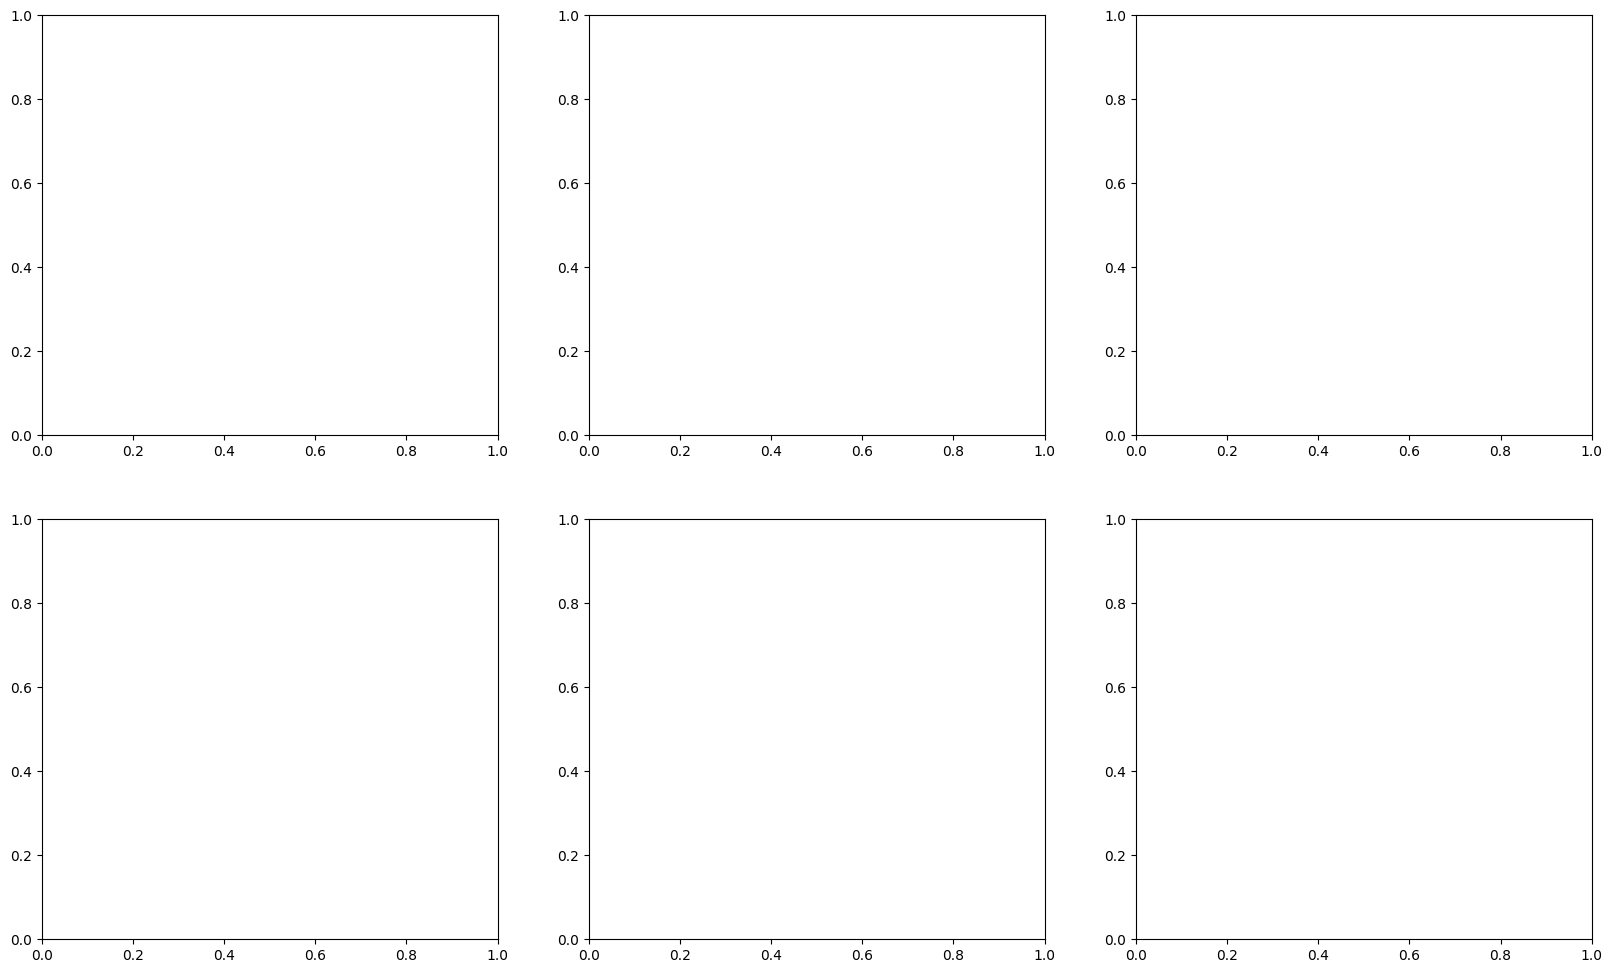

In [ ]:
# ==========================================
# 📈 7. Visualization
# ==========================================

print("\n" + "="*80)
print("📈 Creating Visualizations")
print("="*80)

fig, axes = plt.subplots(2, 3, figsize=(20, 12))

# 1. Test Performance Comparison
axes[0, 0].barh(results_df_sorted['Method'], results_df_sorted['Test_Balanced_Acc'], 
               color='steelblue', alpha=0.7)
axes[0, 0].set_xlabel('Test Balanced Accuracy')
axes[0, 0].set_title('Test Performance Comparison')
axes[0, 0].grid(axis='x', alpha=0.3)
for i, v in enumerate(results_df_sorted['Test_Balanced_Acc']):
    axes[0, 0].text(v + 0.005, i, f'{v:.4f}', va='center', fontsize=9)

# 2. Training Time Comparison
axes[0, 1].barh(results_df_sorted['Method'], results_df_sorted['Time_min'], 
               color='coral', alpha=0.7)
axes[0, 1].set_xlabel('Training Time (minutes)')
axes[0, 1].set_title('Training Time Comparison')
axes[0, 1].grid(axis='x', alpha=0.3)

# 3. Efficiency (Score per Minute)
axes[0, 2].barh(efficiency_sorted['Method'], efficiency_sorted['Score_per_Minute'], 
               color='lightgreen', alpha=0.7)
axes[0, 2].set_xlabel('Score per Minute (Higher = Better)')
axes[0, 2].set_title('Efficiency:  Performance per Time Unit')
axes[0, 2].grid(axis='x', alpha=0.3)

# 4. CV Score vs Test Score
axes[1, 0]. scatter(results_df['CV_Score'], results_df['Test_Balanced_Acc'], 
                  s=200, alpha=0.6, c=results_df['Time_min'], 
                  cmap='viridis', edgecolors='black', linewidth=2)
for idx, row in results_df.iterrows():
    axes[1, 0].annotate(row['Method'], (row['CV_Score'], row['Test_Balanced_Acc']),
                       fontsize=8, alpha=0.8, ha='center')
axes[1, 0].plot([0.5, 1], [0.5, 1], 'k--', alpha=0.3, label='Perfect Agreement')
axes[1, 0].set_xlabel('CV Score')
axes[1, 0]. set_ylabel('Test Score')
axes[1, 0].set_title('CV vs Test Performance\n(Color = Training Time)')
axes[1, 0].legend()
axes[1, 0].grid(alpha=0.3)
plt.colorbar(axes[1, 0].collections[0], ax=axes[1, 0], label='Time (min)')

# 5. Precision-Recall Trade-off
axes[1, 1].scatter(results_df['Test_Recall'], results_df['Test_Precision'],
                  s=200, alpha=0.6, c=results_df['Test_F1'],
                  cmap='RdYlGn', edgecolors='black', linewidth=2)
for idx, row in results_df. iterrows():
    axes[1, 1].annotate(row['Method'], (row['Test_Recall'], row['Test_Precision']),
                       fontsize=8, alpha=0.8, ha='center')
axes[1, 1].set_xlabel('Recall')
axes[1, 1].set_ylabel('Precision')
axes[1, 1].set_title('Precision-Recall Trade-off\n(Color = F1-Score)')
axes[1, 1].grid(alpha=0.3)
plt.colorbar(axes[1, 1].collections[0], ax=axes[1, 1], label='F1-Score')

# 6. Overfitting Analysis
valid_gap = results_df. dropna(subset=['Train_CV_Gap'])
if len(valid_gap) > 0:
    axes[1, 2].scatter(valid_gap['Train_CV_Gap'], valid_gap['Test_Balanced_Acc'],
                      s=200, alpha=0.6, c=valid_gap['CV_Score'],
                      cmap='coolwarm', edgecolors='black', linewidth=2)
    for idx, row in valid_gap.iterrows():
        axes[1, 2].annotate(row['Method'], (row['Train_CV_Gap'], row['Test_Balanced_Acc']),
                           fontsize=8, alpha=0.8, ha='center')
    axes[1, 2].axvline(x=0.05, color='orange', linestyle='--', alpha=0.5, label='Minor Overfitting')
    axes[1, 2].axvline(x=0.10, color='red', linestyle='--', alpha=0.5, label='High Overfitting')
    axes[1, 2].set_xlabel('Train-CV Gap')
    axes[1, 2].set_ylabel('Test Balanced Accuracy')
    axes[1, 2].set_title('Overfitting Analysis\n(Color = CV Score)')
    axes[1, 2].legend()
    axes[1, 2].grid(alpha=0.3)
    plt.colorbar(axes[1, 2].collections[0], ax=axes[1, 2], label='CV Score')
else:
    axes[1, 2].text(0.5, 0.5, 'Overfitting data\nnot available', 
                   ha='center', va='center', fontsize=12)
    axes[1, 2].set_title('Overfitting Analysis')

plt.tight_layout()
plt.savefig('models/tuning_comparison/comparison_visualization.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Saved: models/tuning_comparison/comparison_visualization.png")



In [ ]:
# ==========================================
# 🎯 8. Final Recommendations
# ==========================================

print("\n" + "="*120)
print("🎯 FINAL RECOMMENDATIONS")
print("="*120)

# ตรวจสอบว่ามีผลลัพธ์หรือไม่
if len(results) == 0 or 'results_df_sorted' not in locals():
    print("\n❌ No results available for recommendations.")
    print("   Please run the comparison cell (cell 12) first.")
else:
    best_overall = results_df_sorted.iloc[0]
    print(f"\n🥇 BEST OVERALL METHOD:")
    print(f"   Method:               {best_overall['Method']}")
    print(f"   Test Balanced Acc:   {best_overall['Test_Balanced_Acc']:.4f}")
    print(f"   Test F1:             {best_overall['Test_F1']:.4f}")
    print(f"   Training Time:       {best_overall['Time_min']:.2f} min")
    print(f"   Iterations:          {best_overall['N_Iterations']:.0f}")

    best_fast = efficiency_sorted.iloc[0]
    print(f"\n⚡ MOST EFFICIENT METHOD:")
    print(f"   Method:              {best_fast['Method']}")
    print(f"   Test Balanced Acc:   {best_fast['Test_Balanced_Acc']:.4f}")
    print(f"   Training Time:       {best_fast['Time_min']:.2f} min")
    print(f"   Score per Minute:    {best_fast['Score_per_Minute']:.4f}")

    best_stable = results_df.loc[results_df['CV_Std'].idxmin()] if 'CV_Std' in results_df.columns else None
    if best_stable is not None and not np.isnan(best_stable['CV_Std']):
        print(f"\n🎯 MOST STABLE METHOD:")
        print(f"   Method:              {best_stable['Method']}")
        print(f"   CV Score:            {best_stable['CV_Score']:.4f} ± {best_stable['CV_Std']:.4f}")
        print(f"   Test Balanced Acc:   {best_stable['Test_Balanced_Acc']:.4f}")

    print("\n" + "="*120)
    print("💡 INSIGHTS:")
    print("="*120)

    print("""
1. **RandomizedSearchCV**:  
   - ดี:  เร็ว, explore parameter space กว้าง
   - เหมาะกับ: เริ่มต้น, parameter space ใหญ่

2. **GridSearchCV**: 
   - ดี: ค้นหาอย่างละเอียด, reproducible
   - เหมาะกับ: parameter space เล็ก, ต้องการค้นหาทุก combination

3. **BayesSearchCV**: 
   - ดี: intelligent search, มักได้ผลดีกว่า random
   - เหมาะกับ: มีเวลาพอสมควร, ต้องการ optimize

4. **OptunaSearchCV**: 
   - ดี: modern, flexible, มี pruning
   - เหมาะกับ: โปรเจค production, ต้องการ logging ดี

5. **HalvingRandomSearch**: 
   - ดี: เร็วมาก, early stopping
   - เหมาะกับ: dataset ใหญ่, ต้องการความเร็ว
""")

    print("\n" + "="*120)
    print("✅ TUNING METHOD COMPARISON COMPLETED!")
    print("="*120)
